In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [4]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ASD','AUD','BIL. CHIR','BIP','CUD','EPILEPSY','FATIGUE','GOUT','HOARDING','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PTSD','RH. ARTHRITIS','SJOGRENS','SZC','THYROID DIS.','TOURETTES']

In [5]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [6]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [7]:
df_list[0]

,p1,p2,rg,se,z,p
0,munged/ADHD.sumstats.gz,munged/ANOREXIA.sumstats.gz,-0.0931,0.0370,-2.5141,1.193500e-02
1,munged/ADHD.sumstats.gz,munged/ANXIETY.sumstats.gz,0.3234,0.1350,2.3950,1.661900e-02
2,munged/ADHD.sumstats.gz,munged/ASD.sumstats.gz,0.4326,0.0513,8.4319,3.402200e-17
3,munged/ADHD.sumstats.gz,munged/AUD.sumstats.gz,-0.0135,0.0261,-0.5154,6.062400e-01
4,munged/ADHD.sumstats.gz,munged/BIL_CHIR.sumstats.gz,0.0809,0.0416,1.9447,5.181000e-02
5,munged/ADHD.sumstats.gz,munged/BIP.sumstats.gz,0.2366,0.0331,7.1576,8.210900e-13
6,munged/ADHD.sumstats.gz,munged/CUD.sumstats.gz,0.6633,0.0428,15.4853,4.359100e-54
7,munged/ADHD.sumstats.gz,munged/EPILEPSY.sumstats.gz,0.1418,0.0539,2.6332,8.458800e-03
8,munged/ADHD.sumstats.gz,munged/FATIGUE.sumstats.gz,0.0760,0.0718,1.0575,2.902800e-01
9,munged/ADHD.sumstats.gz,munged/GOUT.sumstats.gz,0.0647,0.0371,1.7435,8.125000e-02


In [8]:
#function to fill a dataframe with values from the ldsc analysis

def make_correlation_matrix(column, df_list):
    array = np.zeros((len(disorders), len(disorders)))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            for j in range(i + 1, len(val) + 1 + i):  # exclude the diagonal
                array[j, i] = val[j - i - 1]
                

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else: np.fill_diagonal(array,0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array

In [9]:
corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix('rg', df_list)

In [10]:
corr_matrix

array([[ 1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [-9.310e-02,  1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00],
       [ 3.234e-01, -2.092e-01,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000

In [11]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)

In [12]:
full_df.head()

,ADHD,ANOREXIA,ANXIETY,ASD,AUD,BIL. CHIR,BIP,CUD,EPILEPSY,FATIGUE,...,OCD,OD,PANIC,PARKINSONS,PTSD,RH. ARTHRITIS,SJOGRENS,SZC,THYROID DIS.,TOURETTES
ADHD,1.0000,-0.0931,0.3234,0.4326,-0.0135,0.0809,0.2366,0.6633,0.1418,0.0760,...,-0.1415,0.5329,0.1684,0.1043,0.6884,0.0278,0.1924,0.2032,0.0536,0.1934
ANOREXIA,-0.0931,1.0000,-0.2092,-0.1322,-0.0607,0.0055,-0.2430,-0.0398,-0.0050,-0.0890,...,-0.4461,0.0544,-0.1260,-0.1639,-0.2526,-0.0187,-0.0604,-0.2584,0.0368,-0.1241
ANXIETY,0.3234,-0.2092,1.0000,0.2647,0.1155,0.1038,0.2686,0.3813,0.2590,0.4166,...,0.3196,0.1868,0.6971,-0.3703,0.5628,0.0675,-0.1105,0.3637,0.2525,0.0354
ASD,0.4326,-0.1322,0.2647,1.0000,0.0661,0.0180,0.2183,0.1174,-0.1553,0.2495,...,0.1271,-0.1264,0.1284,0.2718,0.4110,-0.1162,-0.0134,0.2791,0.0600,0.1148
AUD,-0.0135,-0.0607,0.1155,0.0661,1.0000,0.1217,0.0607,0.0542,-0.1035,0.0117,...,-0.0150,0.2322,0.1438,0.5862,0.2368,0.0405,0.1044,0.0466,0.0169,0.1571


In [13]:
full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True)

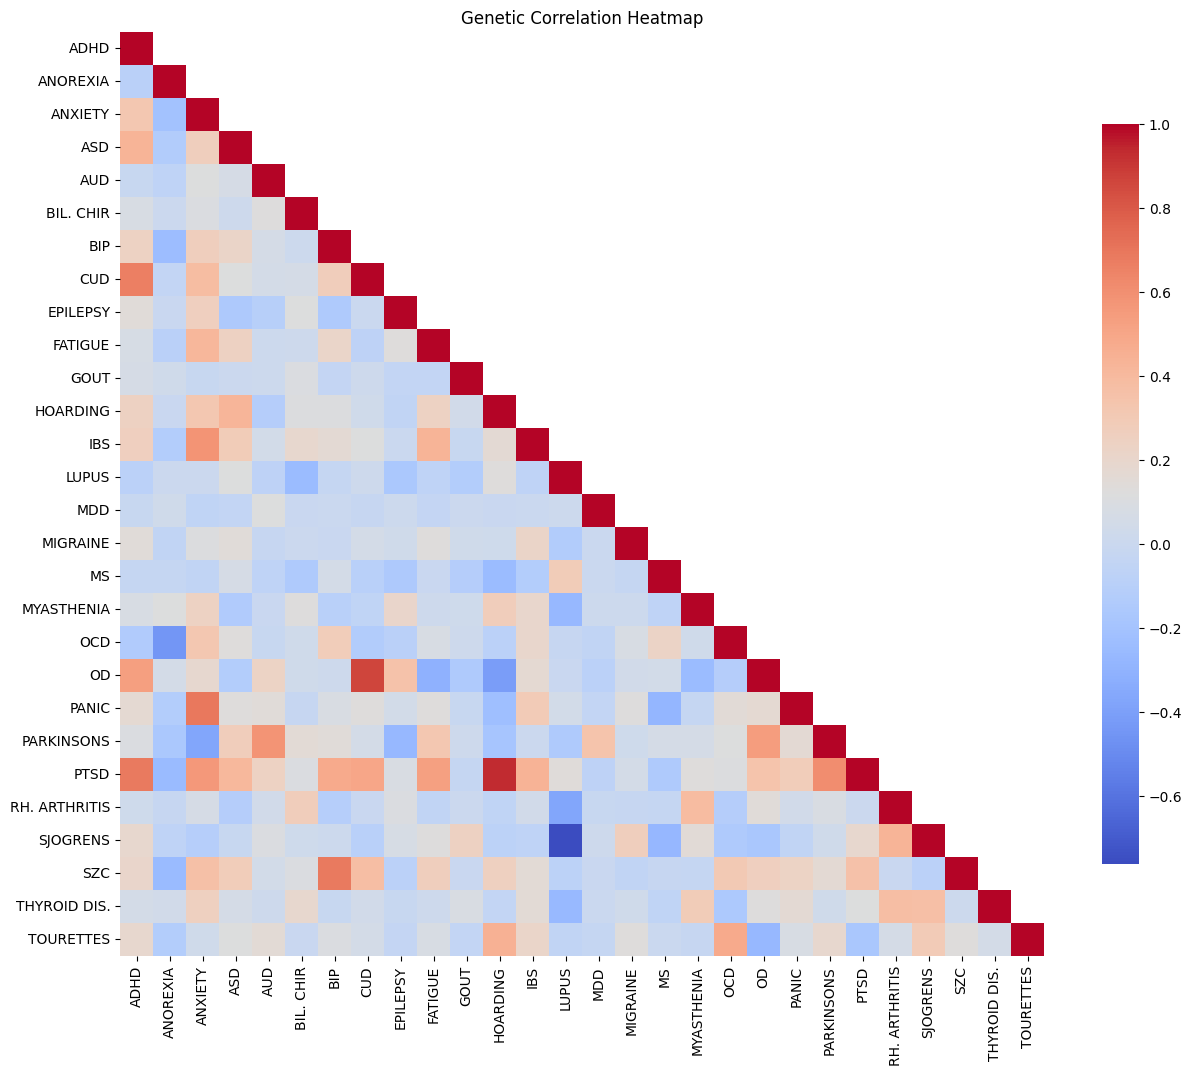

In [14]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(gen_corr_df, cmap='coolwarm',mask=mask, square=True, cbar_kws={"shrink": 0.8})
plt.title('Genetic Correlation Heatmap')
plt.show()

<Figure size 2000x1500 with 0 Axes>

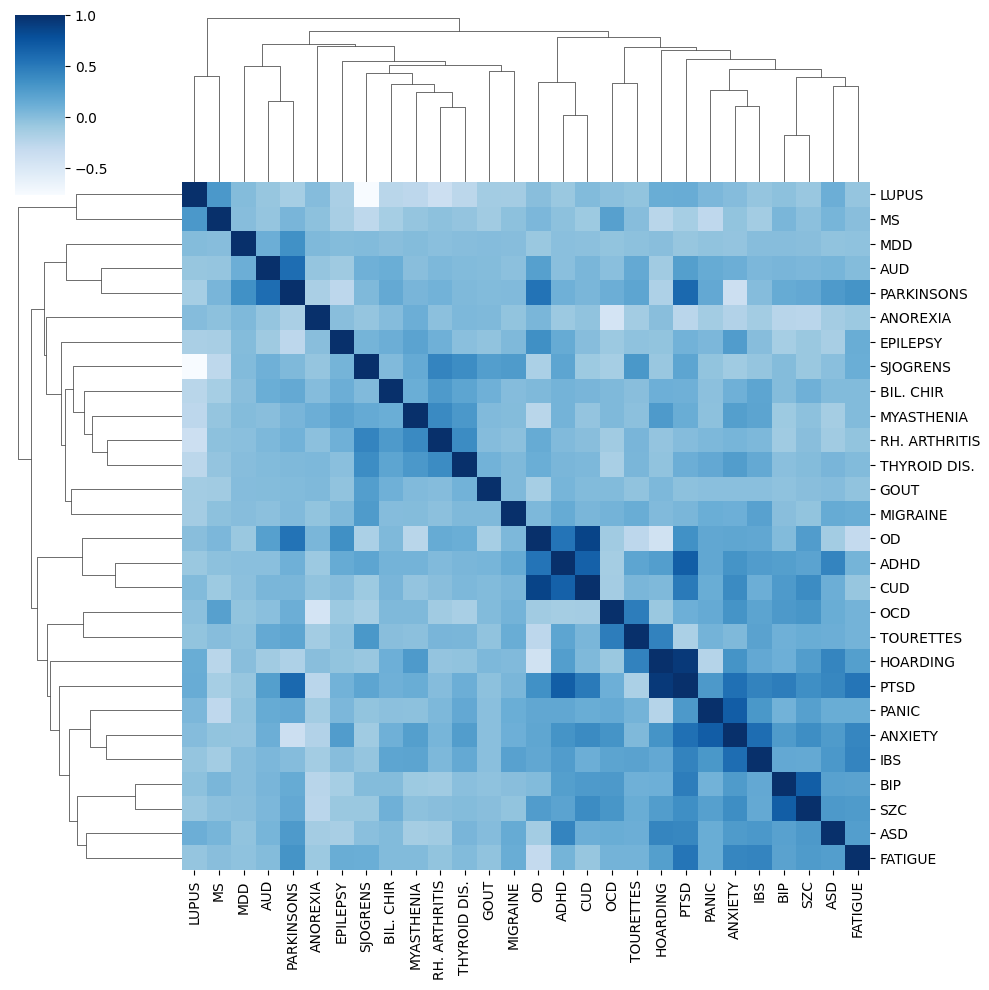

In [16]:
#plot clustermap
plt.figure(figsize=(20,15))
sns.clustermap(full_df,cmap='Blues')
plt.show()